## Load Packages

In [1]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Mounted at /content/drive
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=NkR4lt_uLaHyZrYgybqRBvKlPGsn1nbhUkXEkjoPS-c&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWikDQ6vzOGdDGPC7JVBohPNTAliZNB-kFKOfsI5Ha3tL5wsFQWnYFY

Successfully saved authorization token.


In [2]:
from shapely.geometry import Polygon

In [3]:
!pip install geopandas
#!pip install rioxarray
!pip install geojson
#!pip install rasterstats
!pip install geemap
!pip install scikit-learn
!pip install seaborn

import os
from glob import glob
import numpy as np
import pandas as pd
import geojson
import shapely as shp
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
#import xarray as xr
#import rioxarray as rioxr
import geemap
from sklearn.metrics import roc_curve, auc
#import gdal
import seaborn as sns

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 16.7 MB 34.4 MB/s 
     |████████████████████████████████| 6.3 MB 36.2 MB/s 
     |████████████████████████████████| 1.9 MB 4.0 MB/s 
     |████████████████████████████████| 76 kB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 37.2 MB/s 
     |████████████████████████████████| 8.5 MB 946 kB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 
     |████████████████████████████████| 98 kB 6.8 MB/s 
     |████████████████████████████████| 5.4 MB 43.9 MB/s 
     |████████████████████████████████| 1.7 MB 42.4 MB/s 
     |████████████████████████████████| 44 kB 2.2 MB/s 
     |████████████████████████████████| 216 kB 53.0 MB/s 
     |████████████████████████████████| 130 kB 33.3 MB/s 
     |████████████████████████████████| 1.3 MB 18.1 MB/s 
     |████████████████████████████████| 95 kB 3.3 MB/s 
     |████████████████████████████████| 176 kB 36.6 MB/s 
     |████████████████████

## Load ROIs (parcel)

In [10]:
# Load all parcels
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
path_parcels = glob(os.path.join(os.getcwd(), 'parcels.geojson'))[0]
parcels = gpd.read_file(path_parcels).sort_values('TARGET_FID')

parcels.head()

,fid,TARGET_FID,GID_0,NAME_0,Shape_Area,geometry
0,1,215,JPN,Japan,7.774520e+10,"MULTIPOLYGON (((147.70812 43.07955, 146.24364 ..."
1,2,216,JPN,Japan,6.692903e+10,"MULTIPOLYGON (((143.48255 43.51240, 142.55864 ..."
51,52,336,JPN,Japan,6.854787e+10,"MULTIPOLYGON (((143.48255 43.51240, 145.36744 ..."
52,53,455,JPN,Japan,4.888277e+10,"MULTIPOLYGON (((142.54397 46.95565, 142.55864 ..."
53,54,462,CHN,China,8.068226e+10,"MULTIPOLYGON (((132.39052 41.62522, 130.12027 ..."


In [11]:
# Get Parcel IDs
#parcelIDs = sorted(list(parcels['TARGET_FID']))
parcelIDs = [667, 669, 671]
print(parcelIDs)

[667, 669, 671]


In [12]:
#parcels.to_file('parcels.geojson', driver='GeoJSON')
with open('parcels.geojson') as f:
  parcels_geojson = geojson.load(f)

## Function: Get TPR & FPR

### Level-II Functions

In [13]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [14]:
# Function to add water Index bands
def addIndex(image):
  ndwi = image.normalizedDifference(['green', 'nir']).rename(['ndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431169608948714
  
  mndwi = image.normalizedDifference(['green', 'swir1']).rename(['mndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431160600589179
  
  awei = image.expression("blue + 2.5*green - 1.5*(nir+swir1) - 0.25*swir2", {
    'blue': image.select(['blue']),
    'green': image.select(['green']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['awei'])
  # https://www.sciencedirect.com/science/article/pii/S0034425713002873
  
  wiFi = image.expression("1.7204 + 171*green +3*red - 70*nir - 45*swir1 - 71*swir2",{
    'green': image.select(['green']),
    'red': image.select(['red']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['wiFi'])
  # https://www.sciencedirect.com/science/article/abs/pii/S0034425715302753
  
  return image.addBands([ndwi, mndwi, awei, wiFi])


In [15]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [16]:
# Function of Otsu's Method
def get_threshold(image, waterIndices, roi):
  #indices = ['ndwi', 'mndwi', 'awei', 'wiFi']
  #indices = ['wiFi']
  indices = waterIndices

  histograms = [image.select([i]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True) for i in [indices]]

  thrhs = [otsu(h.get(i+'_histogram')) for h,i in zip(histograms,[indices])]

  return thrhs

In [17]:
def get_mask(image, waterIndices, threshold):
  #indices = ['wiFi']
  indices = waterIndices
  watermasks = [image.select([i]).gt(t).rename(['watermask_'+i]).unmask(0) for i,t in zip([indices],[threshold])]
  # Water = 1, Land = 0
  return watermasks

In [18]:
#i = 'awei'
#t = [2.5]
#[[i,t] for i,t in zip([i], t)]

### Level-I Functions

In [19]:
def rasterize_testSite(parcelID):

  # Load Test Site
  os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/ROC_testSites/')
  testSites = glob(os.path.join(os.getcwd(), "*"+str(parcelID)+"*"))
  with open(testSites[0].split('/')[-1]) as f:
    testSite_geojson = geojson.load(f)

  # Create Feature Collection of all ponds at test site
  geoms = [ee.Geometry(i['geometry']) for i in testSite_geojson['features']]
  features = [ee.Feature(i) for i in geoms]
  featCol = ee.FeatureCollection(features).map(lambda feature: feature.set('ref', 1))

  # Rasterize test site: pond = 1, land = 0
  bbox = featCol.union().geometry().bounds()
  img_ref = featCol.reduceToImage(['ref'], ee.Reducer.firstNonNull()).unmask(0).clip(bbox)
  img_ref = img_ref.rename(['reference'])

  return img_ref, bbox

In [20]:
def get_roi(parcelID):

  ROI = [i['geometry'] for i in parcels_geojson['features'] if i['properties']['TARGET_FID']==parcelID]
  roi = ee.Geometry(ROI[0])
  
  return roi

In [21]:
def get_index_img(roi, reducer):

  # Load Landsat Archives
  ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
          .filterDate('2019', '2020') \
          .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
          .filterBounds(roi) \
          .sort("system:time_start", True)
  ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
        .filterDate('2019', '2020') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(roi) \
        .sort("system:time_start", True)

  # Merge Collections + Mask Cloud + Add water index bands
  ls_all = ls8.merge(ls7)
  ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

  # Reduce by Median
  if reducer=='median':
    index_img = ls_all.median().set({'year': 2019, 'system:time_start': ee.Date.fromYMD(2019, 12, 31)})
  elif reducer=='95th':
    index_img = ls_all.reduce(ee.Reducer.percentile([95])).set({'year': 2019, 'system:time_start': ee.Date.fromYMD(2019, 12, 31)})
  return index_img


In [22]:
def Get_threshold(indexImg, waterIndices, roi):
  # Apply Otsu
  roi = roi
  waterIndices = waterIndices
  threshold_origin = get_threshold(image = indexImg, waterIndices = waterIndices, roi = roi)
  return threshold_origin

In [23]:
def Get_mask(indexImg, threshold, bbox, waterIndices, reducer):
  waterIndices = waterIndices
  reducer = reducer
  img_pred = get_mask(image = indexImg, waterIndices = waterIndices, threshold = threshold)[0].clip(bbox)
  img_pred = img_pred.rename(['pred_'+waterIndices+'_'+reducer])
  return img_pred

In [24]:
def sample_pred_ref_img(img_pred, img_ref, bbox):
  img_to_sample = img_pred.addBands(img_ref)
  my_sample = img_to_sample.sample(bbox, 90)

  property_keys = my_sample.toDictionary().values().getInfo()[0]
  #print(property_keys)
  property_values = [np.array(my_sample.aggregate_array(i).getInfo()) for i in property_keys]
  property_dic = dict(zip(property_keys, property_values))

  pred = property_dic.get(property_keys[0])
  reference = property_dic.get(property_keys[1])

  fp = np.sum((pred == 1) & (reference == 0))
  tp = np.sum((pred == 1) & (reference == 1))

  fn = np.sum((pred == 0) & (reference == 1))
  tn = np.sum((pred == 0) & (reference == 0))

  fpr = fp / (fp + tn)
  tpr = tp / (tp + fn)

  return fpr, tpr

### Level-0 Function

In [25]:
def getEM_single(parcelID, waterIndices, reducer):

  img_ref, bbox = rasterize_testSite(parcelID = parcelID)

  roi = get_roi(parcelID = parcelID)

  index_img = get_index_img(roi = roi, reducer = reducer)

  waterIndices = waterIndices

  threshold = Get_threshold(indexImg = index_img, waterIndices = waterIndices, roi = roi)

  img_pred = Get_mask(indexImg = index_img, threshold = threshold, bbox = bbox, waterIndices = waterIndices, reducer = reducer)

  fpr, tpr = sample_pred_ref_img(img_pred = img_pred, img_ref = img_ref, bbox = bbox)

  return fpr, tpr

In [26]:
def getEM(parcelID, waterIndices, reducer, factors):

  img_ref, bbox = rasterize_testSite(parcelID = parcelID)

  roi = get_roi(parcelID = parcelID)

  index_img = get_index_img(roi = roi, reducer = reducer)

  if reducer == '95th':
    waterIndices = waterIndices+'_p95'
  else:
    waterIndices = waterIndices

  threshold = Get_threshold(indexImg = index_img, waterIndices = waterIndices, roi = roi)
  factors = factors
  thresholds = [i*threshold[0].getInfo() for i in factors]
  
  img_preds = [Get_mask(indexImg = index_img, threshold = threshold, bbox = bbox, waterIndices = waterIndices, reducer = reducer) for threshold in thresholds]

  em = [sample_pred_ref_img(img_pred = img_pred, img_ref = img_ref, bbox = bbox) for img_pred in img_preds]
  return em
  #ls_fpr=[]
  #ls_tpr=[]
  #for img_pred in img_preds:
  #  fpr, tpr = sample_pred_ref_img(img_pred = img_pred, img_ref = img_ref, bbox = bbox)
  #  ls_fpr.append(fpr)
  #  ls_tpr.append(tpr)
  #return ls_fpr, ls_tpr
  

* Copy this function four times, for `wiFi+median`, `wiFi+95th`, `mndwi+median`, `mndwi+95th` combis.

* Merge Output DFs.

In [27]:
#factors = np.arange(0.90, 1.11, 0.01)
#em = getEM(parcelID=667, waterIndices='wiFi', reducer='median', factors=factors)
#print(em)

In [28]:
#df_wiFi_median = pd.DataFrame(list(zip(fpr, tpr)), columns=['fpr', 'tpr'])
#df_wiFi_median = pd.DataFrame(em, columns=['fpr', 'tpr'])
#df_wiFi_median['factors'] = factors
#df_wiFi_median

## Export DFs of TPR & FPR

In [29]:
import itertools as it

In [31]:
outPath = '/content/drive/My Drive/myExportImage/ROC_DFs/'

#parcelIDs = [667, 669, 671]
#indices = ['ndwi', 'mndwi', 'awei', 'wiFi']
#reducers = ['median', '95th']
parcelIDs = [671]
indices = ['wiFi']
reducers = ['95th']
args = list(it.product(parcelIDs, indices, reducers))

def genFun(n): # n = len(args)
  
  factors = np.arange(0.70, 1.30, 0.02)

  i = 0
  while i < n:
    parcelID = args[i][0]
    waterIndex = args[i][1]
    reducer = args[i][2]

    em = getEM(parcelID=parcelID, waterIndices=waterIndex, reducer=reducer, factors=factors)

    df = pd.DataFrame(em, columns=['fpr', 'tpr'])
    df['factors'] = factors
    df['parcelID'] = parcelID
    df['waterIndex'] = waterIndex
    df['reducer'] = reducer

    yield df.to_csv(os.path.join(outPath, 'p_'+str(parcelID)+'_'+waterIndex+'_'+reducer+'.csv'), sep='\t', encoding='utf-8', index=False)
    i += 1

gen = genFun(len(args))

In [32]:
# Exhaust Generator
# Reference: https://stackoverflow.com/questions/47456631/simpler-way-to-run-a-generator-function-without-caring-about-items
from collections import deque

def exhaust(generator):
    deque(generator, maxlen=0)

exhaust(gen)

## ROC

In [120]:
outPath = '/content/drive/My Drive/myExportImage/ROC_DFs/'
files = glob(os.path.join(outPath, "*"))
#files

In [121]:
dfs = [pd.read_csv(i, sep='\t') for i in files]
len(dfs)

24

In [122]:
df = pd.concat(dfs, ignore_index=True)
df.index

RangeIndex(start=0, stop=744, step=1)

### ROC, p-667

In [123]:
df_sub = df[df.parcelID==667]
df_sub.reset_index(drop=True, inplace=True)
df_sub.head()

,fpr,tpr,factors,parcelID,waterIndex,reducer
0,0.005464,0.388350,0.70,667,ndwi,median
1,0.005464,0.391586,0.72,667,ndwi,median
2,0.005464,0.401294,0.74,667,ndwi,median
3,0.005464,0.401294,0.76,667,ndwi,median
4,0.005464,0.411003,0.78,667,ndwi,median


In [124]:
# Find Optimal Threshold
index_optThr = np.argmax(df_sub.tpr - df_sub.fpr)
index_optThr

142

In [125]:
# Params at Optimal Threshold
df_sub.iloc[index_optThr]

fpr           0.081967
tpr           0.919094
factors           1.06
parcelID           667
waterIndex        awei
reducer         median
Name: 142, dtype: object

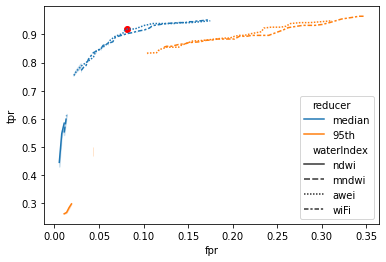

In [126]:
plot = sns.lineplot(data=df_sub, x='fpr', y='tpr', hue='reducer', style='waterIndex')
plt.scatter(x=df_sub.fpr[index_optThr], y=df_sub.tpr[index_optThr], color='r')
#plt.gca().text(df.fpr[index_optThr], df.tpr[index_optThr], 'threshold='+str(df.threshold[index_optThr]))

### ROC, p-669

In [127]:
df_sub = df[df.parcelID==669]
df_sub.reset_index(drop=True, inplace=True)
df_sub.head()

,fpr,tpr,factors,parcelID,waterIndex,reducer
0,0.001129,0.110399,0.70,669,ndwi,median
1,0.001129,0.114544,0.72,669,ndwi,median
2,0.001290,0.118689,0.74,669,ndwi,median
3,0.001451,0.122833,0.76,669,ndwi,median
4,0.001451,0.128862,0.78,669,ndwi,median


In [128]:
# Find Optimal Threshold
index_optThr = np.argmax(df_sub.tpr - df_sub.fpr)
index_optThr

142

In [129]:
# Params at Optimal Threshold
df_sub.iloc[index_optThr]

fpr           0.150597
tpr           0.801055
factors           1.06
parcelID           669
waterIndex        awei
reducer         median
Name: 142, dtype: object

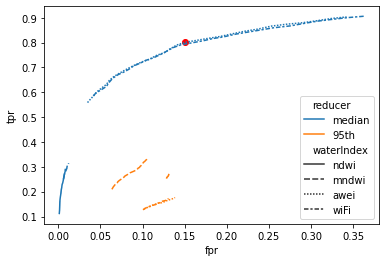

In [130]:
plot = sns.lineplot(data=df_sub, x='fpr', y='tpr', hue='reducer', style='waterIndex')
plt.scatter(x=df_sub.fpr[index_optThr], y=df_sub.tpr[index_optThr], color='r')
#plt.gca().text(df.fpr[index_optThr], df.tpr[index_optThr], 'threshold='+str(df.threshold[index_optThr]))

### ROC, p-671

In [131]:
df_sub = df[df.parcelID==671]
df_sub.reset_index(drop=True, inplace=True)
df_sub.head()

,fpr,tpr,factors,parcelID,waterIndex,reducer
0,0.0,0.060484,0.70,671,ndwi,median
1,0.0,0.060484,0.72,671,ndwi,median
2,0.0,0.060484,0.74,671,ndwi,median
3,0.0,0.060484,0.76,671,ndwi,median
4,0.0,0.068548,0.78,671,ndwi,median


In [132]:
# Find Optimal Threshold
index_optThr = np.argmax(df_sub.tpr - df_sub.fpr)
index_optThr

151

In [133]:
# Params at Optimal Threshold
df_sub.iloc[index_optThr]

fpr           0.145199
tpr           0.818548
factors           1.24
parcelID           671
waterIndex        awei
reducer         median
Name: 151, dtype: object

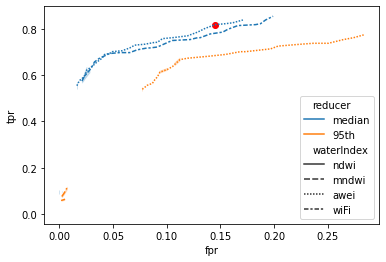

In [134]:
plot = sns.lineplot(data=df_sub, x='fpr', y='tpr', hue='reducer', style='waterIndex')
plt.scatter(x=df_sub.fpr[index_optThr], y=df_sub.tpr[index_optThr], color='r')
#plt.gca().text(df.fpr[index_optThr], df.tpr[index_optThr], 'threshold='+str(df.threshold[index_optThr]))